In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data_path = join('./data', 'train.csv')
sub_data_path = join('./data', 'test.csv')

In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [4]:
# 타겟 피쳐 y로 저장 앤 제거
y = data['price']
del data['price']

# train, test 데이터 합치기
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [5]:
# 데이터 결측치 확인
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [6]:
# test id 저장, id 컬럼 제거
sub_id = data['id'][train_len:]
del data['id']

In [7]:
# 날짜 데이터 string화
data['date'] = data['date'].apply(lambda x : str(x[:6]))

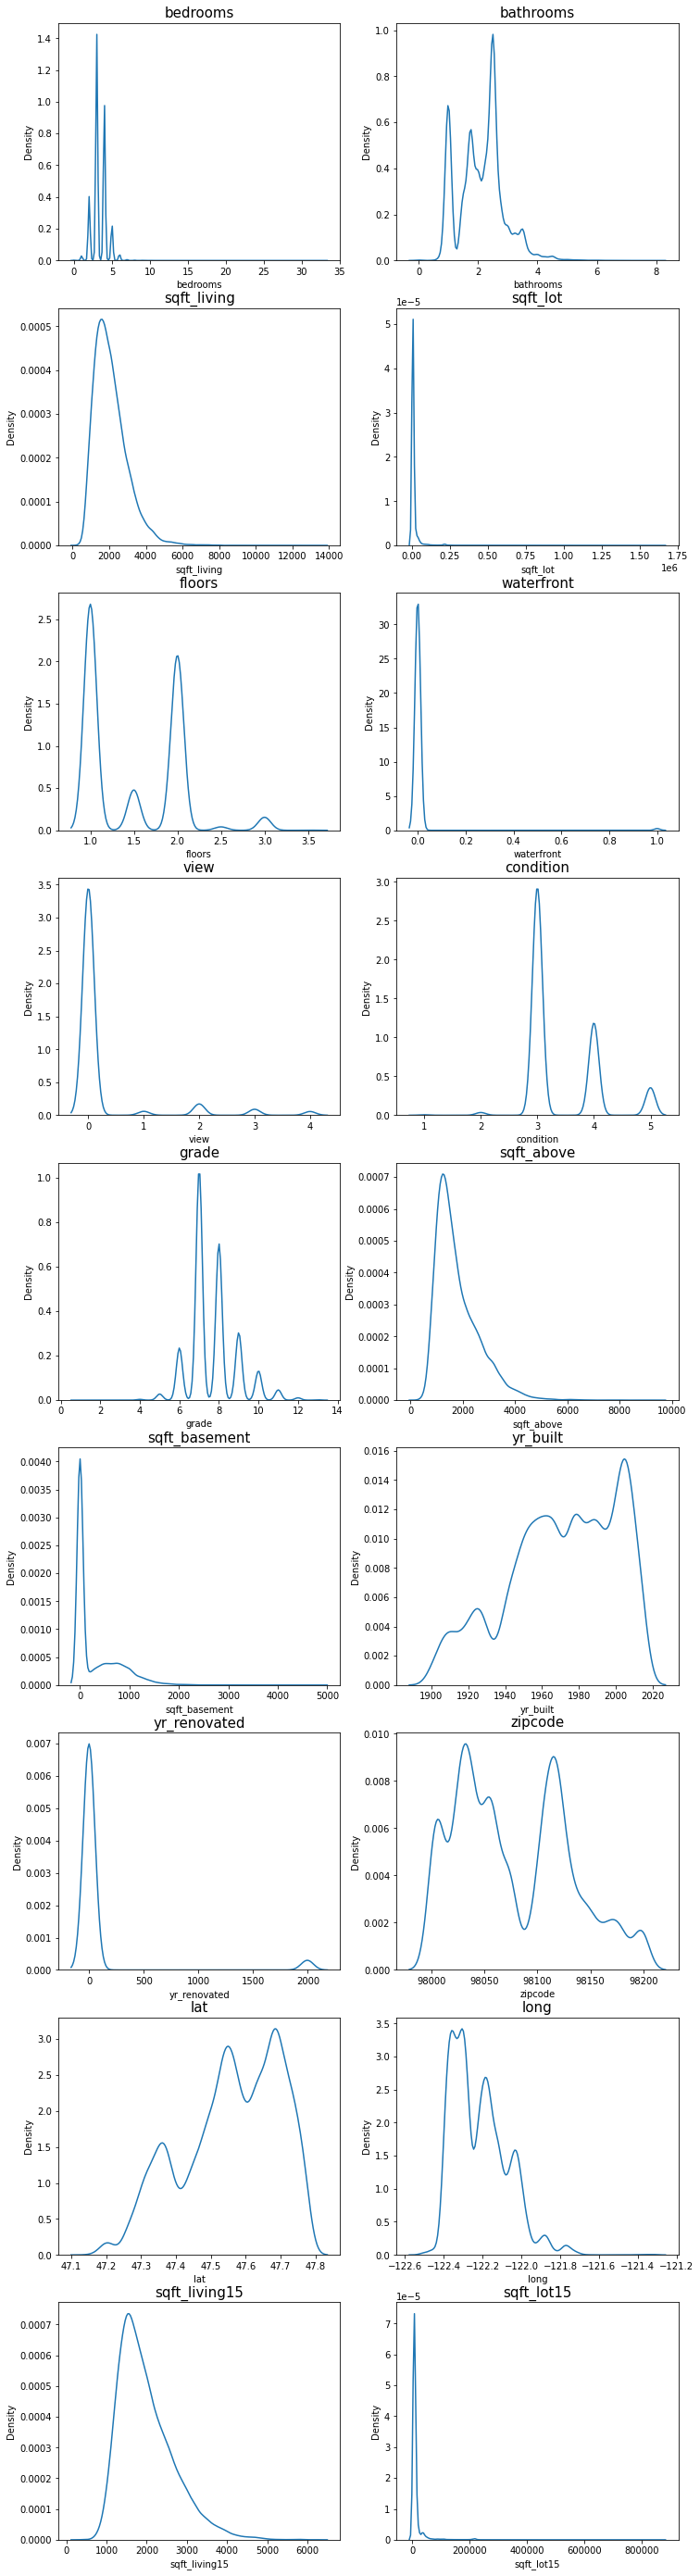

In [8]:
# 데이터 분포 시각화
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [9]:
# 분포가 치우친 컬럼 로그화
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

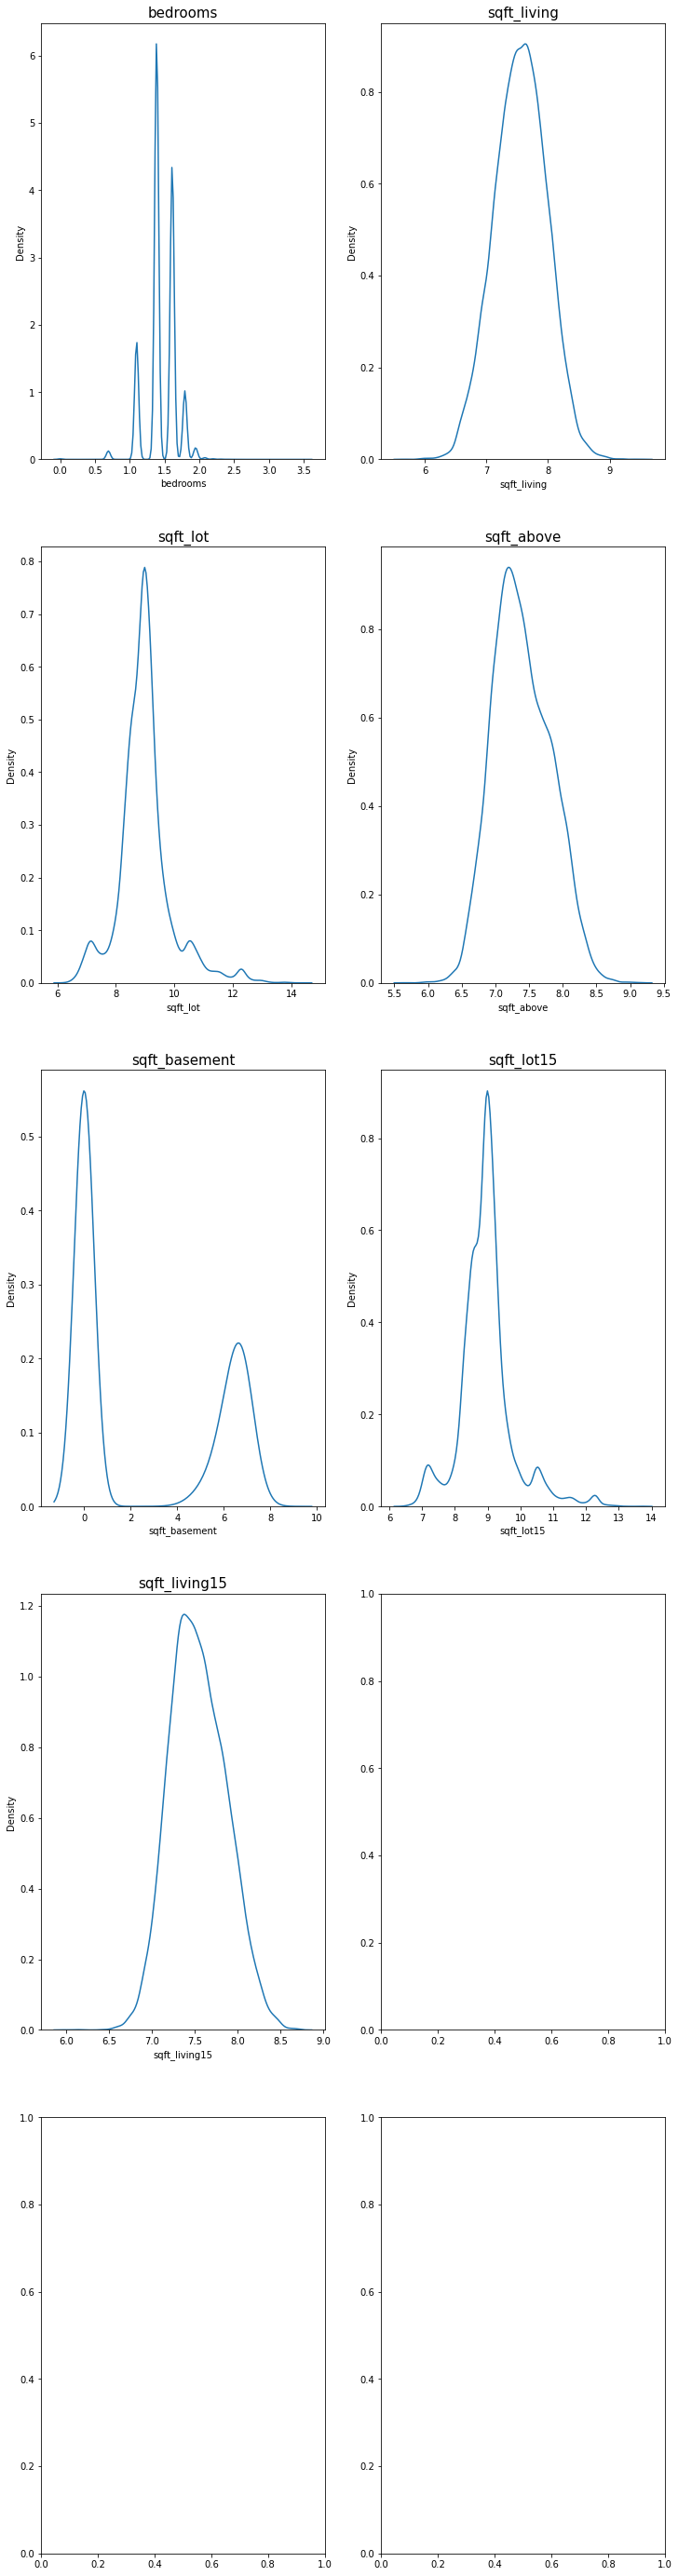

In [10]:
# 로그 후 분포 재확인
fig, ax = plt.subplots(5, 2, figsize=(12, 50))

count = 0
columns = skew_columns
for row in range(int(np.ceil(len(columns)/2))):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == len(columns) :
            break

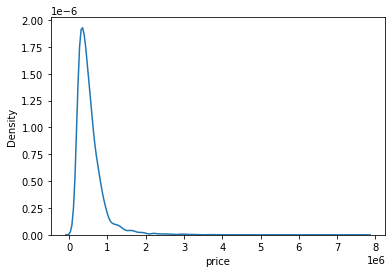

In [11]:
# y 분포 확인
sns.kdeplot(y)
plt.show()

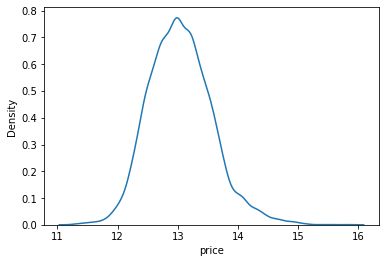

In [12]:
# y log화
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [13]:
# train, sub 분리
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


In [14]:
# 모델 불러오기
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [15]:
# Cross Validation
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
        
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819


In [16]:
# AveragingBlending
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

In [17]:
# submission 데이터 확인
data_dir = './data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [18]:
# 결과 저장
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [19]:
# 결과 저장
my_submission_path = './'
result.to_csv(my_submission_path + 'submission.csv', index=False)

# 하이퍼 파라미터 튜닝

In [20]:
data_dir = './data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [21]:
# date 숫자화
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

In [22]:
# 타겟 컬럼, id 제거
y = train['price']
del train['price']
del train['id']

# test 데이터도 동일하게 수행
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

# y 로그화
y = np.log1p(y)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 로그화된 y값을 expm1으로 복원 후 rmse 계산하기
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# 모델 불러오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=980417

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [24]:
# 모델에 따른 스코어 계산하기
def get_scores(models, train, y):
    
    df = {}
    
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리
        # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=random_state)

        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

get_scores(models, train, y)

,RMSE
RandomForestRegressor,145613.146306
GradientBoostingRegressor,140777.212290
XGBRegressor,126812.239384
LGBMRegressor,122813.622366


In [25]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)

grid_model = GridSearchCV(model, param_grid=param_grid,
                        scoring='neg_mean_squared_error',
                        cv=5, verbose=5, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=980417), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=5)

In [26]:
# 파라미터와 스코어 데이터프레임으로 저장하가
params = grid_model.cv_results_['params']
score = grid_model.cv_results_['mean_test_score']

results = pd.DataFrame(params)
results['score'] = score

results['RMSE'] = np.sqrt(-1 * results['score'])
results = results.rename(columns={'RMSE': 'RMSLE'})
results = results.sort_values(by='RMSLE')

results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [27]:
# GridSearchCV 과정 함수화
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

# 코드 입력
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [28]:
# 함수 활용하여 gridsearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

# fit & predict
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [29]:
# y 값 복원 & 저장
prediction = np.expm1(prediction)
data_dir = './data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = prediction

submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
# print(submission_csv_path)

In [30]:
# y값 예측, 복원, 저장 함수화
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = './data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [31]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.164399')

./data/submission_lgbm_RMSLE_0.164399.csv saved!


# 예측 성능을 높여보자
- 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
- LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
- Baseline 커널에서 활용했던 블렌딩 방법 활용하기

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
# 데이터 불러오기
train_data_path = join('./data', 'train.csv')
sub_data_path = join('./data', 'test.csv')

train = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [6]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [7]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

In [14]:
data_unique = train['date'].unique()
# len(data_unique) # 365
pd.to_datetime(data_unique).sort_values() # 2014.05.02~2015.05.14 

plt.boxplot()

DatetimeIndex(['2014-05-02', '2014-05-03', '2014-05-04', '2014-05-05',
               '2014-05-06', '2014-05-07', '2014-05-08', '2014-05-09',
               '2014-05-10', '2014-05-11',
               ...
               '2015-05-05', '2015-05-06', '2015-05-07', '2015-05-08',
               '2015-05-09', '2015-05-10', '2015-05-11', '2015-05-12',
               '2015-05-13', '2015-05-14'],
              dtype='datetime64[ns]', length=365, freq=None)

In [31]:
train['waterfront'].unique(), train['view'].unique(), train['condition'].unique()

(array([0, 1]), array([0, 3, 4, 2, 1]), array([3, 4, 5, 2, 1]))

In [ ]:
# 전처리 방향
'''
id컬럼 삭제
date : 년, 월, 일
price : None, 정규화
bedrooms : 범주형으로
bathrooms : 범주형으로
sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15 : 정규화
floors : 원핫벡터
waterfront : 그대로
condition : 3 미만 / 3이상
view : 원핫벡터
grade : 그냥 놔두기기
yr_built : 현재 년도에서 뺴기
yr_renovated : 0이면 0, 현재연도 - 재건축 연도
zip : 우편번호로 지역 변환
lat, long : 지역 변환
'''

In [127]:
# X, y 분리
train_y = train['price']
train_X = train.drop(['price'], axis=1)

train_X_raw = train_X.copy(deep=True)
train_y_raw = train_y.copy(deep=True)

train_X.shape, train_y.shape

((15035, 20), (15035,))

In [143]:
from sklearn.preprocessing import StandardScaler

# 전처리
train_X = train_X_raw.copy(deep=True)

train_X = train_X.drop(['id'], axis=1)

train_X['date'] = pd.to_datetime(train_X['date'])
train_X['year'] = train_X['date'].dt.year
year_data = train_X['year']
train_X['month'] = train_X['date'].dt.month
train_X['day'] = train_X['date'].dt.day
train_X['year_month'] = train_X['year'].astype(str) + "_" + train_X['month'].astype(str)
train_X = train_X.drop(['date', 'year', 'month', 'day'], axis=1)

# bedrooms 0~2 / 3~6 / 7~10 으로 범주화 시킨다
train_X['bedrooms'] = np.where(train_X['bedrooms']<=2, 'two', np.where(train_X['bedrooms']<=6, 'six', 'ten'))

# bathrooms 1 미만 / 1초과3미만 / 3이상상~5미만 / 5이상
train_X['bathrooms'] = np.where(train_X['bathrooms']<1, 'one', np.where(train_X['bathrooms']<3, 'three', np.where(train_X['bathrooms']<5, 'five', 'ten')))

# 정규화화
scaler_0 = StandardScaler()
train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']] = scaler_0.fit_transform(train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']])

# floors, view 원핫벡터
train_X[['floors', 'view']] = train_X[['floors', 'view']].astype(str)

# condition : 3 미만 / 3이상
train_X['condition'] = np.where(train_X['condition']<3, 'three', 'five')

# yr_built : 현재 년도에서 뺴기
train_X['yr_built'] = year_data - train_X['yr_built'] + 1

# yr_renovated : 0이면 0, 현재연도 - 재건축 연도
train_X['yr_renovated2'] = year_data - train_X['yr_renovated'] + 1
train_X['yr_renovated2'] = np.where(train_X['yr_renovated']==0, 0, train_X['yr_renovated2'])
train_X['yr_renovated'] = train_X['yr_renovated2']
train_X = train_X.drop(['yr_renovated2'], axis=1)

# zip, lat, long 은 우선 날린다.
train_X = train_X.drop(['zipcode', 'lat', 'long'], axis=1)

# get_dummies
train_X = pd.get_dummies(train_X)

print(train_X.iloc[0, :])

sqft_living           -0.98014
sqft_lot             -0.226394
waterfront                   0
grade                        7
sqft_above           -0.738427
sqft_basement        -0.657286
yr_built                    60
yr_renovated                 0
sqft_living15         -0.94406
sqft_lot15           -0.258655
bedrooms_six              True
bedrooms_ten             False
bedrooms_two             False
bathrooms_five           False
bathrooms_one            False
bathrooms_ten            False
bathrooms_three           True
floors_1.0                True
floors_1.5               False
floors_2.0               False
floors_2.5               False
floors_3.0               False
floors_3.5               False
view_0                    True
view_1                   False
view_2                   False
view_3                   False
view_4                   False
condition_five            True
condition_three          False
year_month_2014_10        True
year_month_2014_11       False
year_mon

In [111]:
train_X.columns

Index(['sqft_living', 'sqft_lot', 'waterfront', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15', 'bedrooms_six', 'bedrooms_ten', 'bedrooms_two',
       'bathrooms_five', 'bathrooms_one', 'bathrooms_ten', 'bathrooms_three',
       'floors_1.0', 'floors_1.5', 'floors_2.0', 'floors_2.5', 'floors_3.0',
       'floors_3.5', 'view_0', 'view_1', 'view_2', 'view_3', 'view_4',
       'condition_five', 'condition_three', 'year_month_2014_10',
       'year_month_2014_11', 'year_month_2014_12', 'year_month_2014_5',
       'year_month_2014_6', 'year_month_2014_7', 'year_month_2014_8',
       'year_month_2014_9', 'year_month_2015_1', 'year_month_2015_2',
       'year_month_2015_3', 'year_month_2015_4', 'year_month_2015_5'],
      dtype='object')

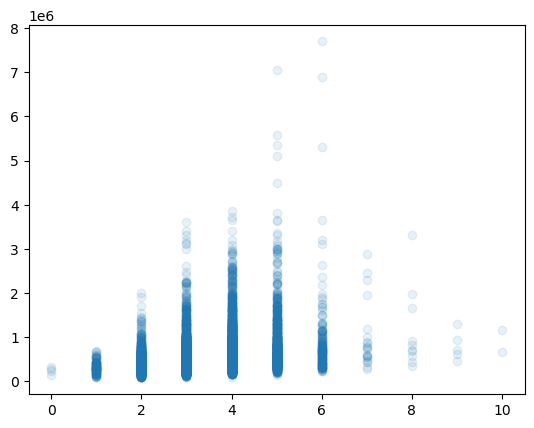

In [59]:
plt.scatter(x=train_X['bedrooms'], y=train['price'], alpha=0.1)
plt.show() # 0~2 / 3~6 / 7~10 으로 범주화 시킨다

In [66]:
pd.value_counts(train_X['bathrooms']).sort_index()

bathrooms
0.00       4
0.50       3
0.75      45
1.00    2675
1.25       5
1.50    1009
1.75    2112
2.00    1357
2.25    1433
2.50    3748
2.75     843
3.00     493
3.25     410
3.50     510
3.75     108
4.00     100
4.25      57
4.50      64
4.75      16
5.00      14
5.25      11
5.50       7
5.75       3
6.00       2
6.25       1
6.75       1
7.50       1
7.75       1
8.00       2
Name: count, dtype: int64

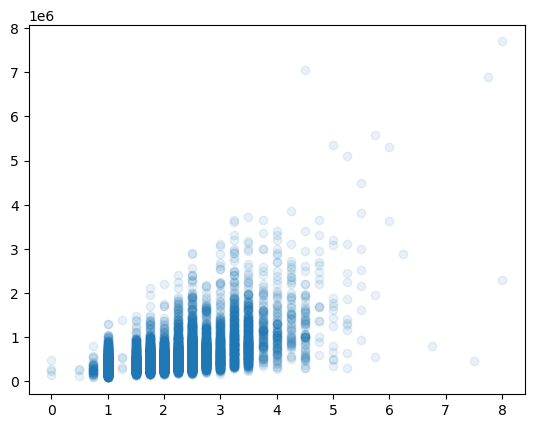

In [64]:
plt.scatter(x=train_X['bathrooms'], y=train['price'], alpha=0.1)
plt.show() # 1 미만 / 1초과3미만 / 3초과~5미만 / 5이상

In [65]:
np.correlate(train_X['bathrooms'], train['price'])

array([1.94464279e+10])

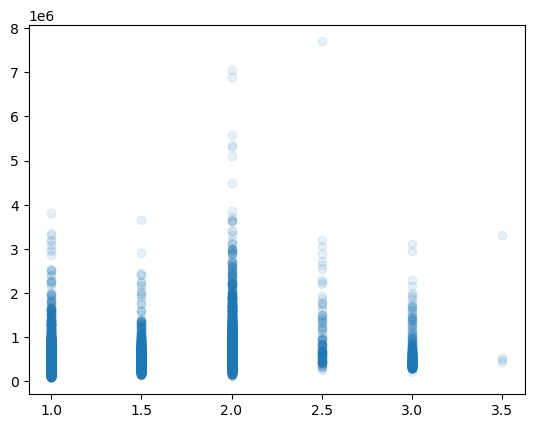

In [75]:
plt.scatter(x=train_X['floors'], y=train['price'], alpha=0.1)
plt.show() # 1 미만 / 1초과3미만 / 3초과~5미만 / 5이상

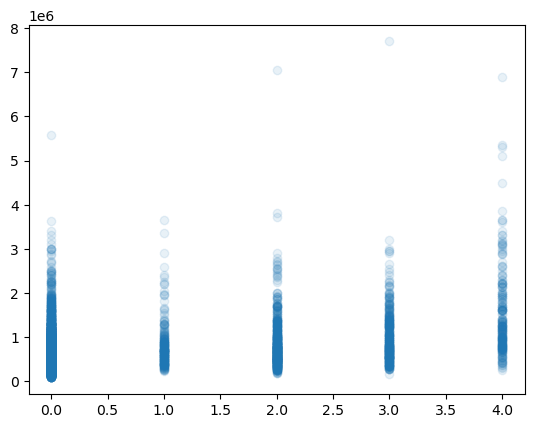

In [76]:
plt.scatter(x=train_X['view'], y=train['price'], alpha=0.1)
plt.show() # 원핫벡터

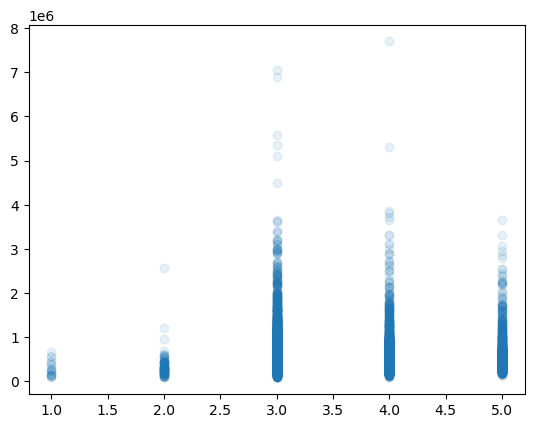

In [77]:
plt.scatter(x=train_X['condition'], y=train['price'], alpha=0.1)
plt.show() # 3 미만 / 3이상

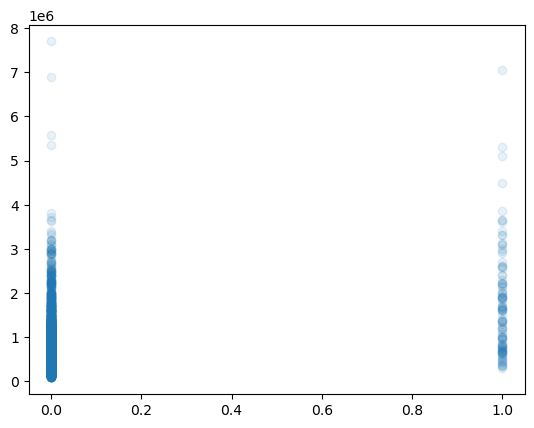

In [81]:
plt.scatter(x=train_X['waterfront'], y=train['price'], alpha=0.1)
plt.show() # 그대로

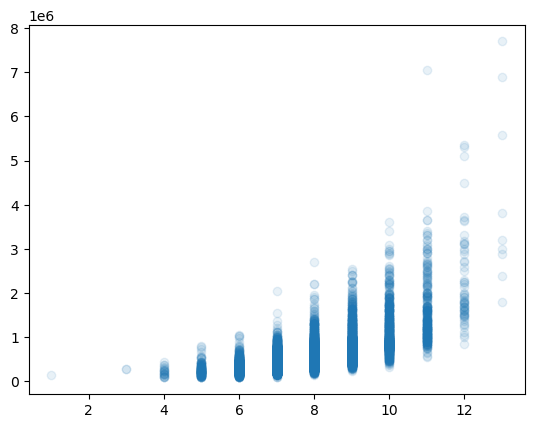

In [78]:
plt.scatter(x=train_X['grade'], y=train['price'], alpha=0.1)
plt.show() # 1 미만 / 1초과3미만 / 3초과~5미만 / 5이상

In [ ]:
# 모델링
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [113]:
# train, test 분리
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, random_state=980417, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12028, 43), (3007, 43), (12028,), (3007,))

In [116]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_pred=y_pred, y_true=y_test)
rmse = mse**0.5
print(rmse)

210051.8356272314


In [ ]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_pred=y_pred, y_true=y_test)
rmse = mse**0.5
print(rmse)

In [120]:
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [10, 20, 30]
}

model = RandomForestRegressor(random_state=980417)

grid_model = GridSearchCV(model, param_grid=param_grid,
                        scoring='neg_mean_squared_error',
                        cv=5, verbose=5, n_jobs=5)

grid_model.fit(X_train, y_train)

y_pred = grid_model.predict(X_test)
mse = mean_squared_error(y_pred=y_pred, y_true=y_test)
rmse = mse**0.5
print(rmse)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 5/5] END max_depth=10, n_estimators=100;, score=-29372679340.973 total time=   4.3s
[CV 3/5] END max_depth=10, n_estimators=100;, score=-36575447204.876 total time=   4.3s
[CV 4/5] END max_depth=10, n_estimators=100;, score=-41655128974.870 total time=   4.3s
[CV 2/5] END max_depth=10, n_estimators=100;, score=-36415714240.621 total time=   4.3s
[CV 1/5] END max_depth=10, n_estimators=100;, score=-37013973314.999 total time=   4.4s
[CV 2/5] END max_depth=10, n_estimators=500;, score=-34895464425.066 total time=  21.7s
[CV 1/5] END max_depth=10, n_estimators=500;, score=-36791482134.486 total time=  21.7s
[CV 4/5] END max_depth=10, n_estimators=500;, score=-42039246469.049 total time=  21.7s
[CV 3/5] END max_depth=10, n_estimators=500;, score=-36834969743.982 total time=  21.8s
[CV 5/5] END max_depth=10, n_estimators=500;, score=-29119996289.612 total time=  21.8s
[CV 1/5] END max_depth=10, n_estimators=1000;, score=-368414

In [135]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

random_state=980417

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm]

In [124]:
# 모델에 따른 스코어 계산하기
def get_scores(models, X_train, X_test, y_train, y_test):
    
    df = {}
    
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        mse = mean_squared_error(y_pred=y_pred, y_true=y_test)
        rmse = mse**0.5
        df[model_name] = rmse
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

get_scores(models, X_train, X_test, y_train, y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1714
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 42
[LightGBM] [Info] Start training from score 540502.967576


,RMSE
XGBRegressor,205264.463333
GradientBoostingRegressor,199380.128575
LGBMRegressor,190234.303609


In [136]:
# y값에 log1p 적용
train_y = train_y_raw.copy(deep=True)
train_y = np.log1p(train_y)

def rmse_log1p(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [137]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, random_state=980417, test_size=0.2)

In [138]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=980417

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [139]:
# 모델에 따른 스코어 계산하기
def get_scores(models, X_train, X_test, y_train, y_test):
    
    df = {}
    
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse_log1p(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

get_scores(models, X_train, X_test, y_train, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1714
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 42
[LightGBM] [Info] Start training from score 13.049089


,RMSE
RandomForestRegressor,208068.331846
GradientBoostingRegressor,198133.091626
XGBRegressor,193176.355584
LGBMRegressor,183902.025173


In [214]:
# 기존모델에서 바꾸기

# 데이터 불러오기
train_data_path = join('./data', 'train.csv')
sub_data_path = join('./data', 'test.csv')

train = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)

train_y = train['price']
train_X = train.drop(['price'], axis=1)

# X, y 분리
train_X_raw = train_X.copy(deep=True)
train_y_raw = train_y.copy(deep=True)

train_X.shape, train_y.shape

((15035, 20), (15035,))

In [167]:
from sklearn.preprocessing import StandardScaler

# 전처리
train_X = train_X_raw.copy(deep=True)

train_X = train_X.drop(['id'], axis=1)

# 분포가 치우친 컬럼 로그화
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train_X[c] = np.log1p(train_X[c].values)

# # 날짜 데이터 바꾸기
# train_X['date'] = pd.to_datetime(train_X['date'])
# train_X['year'] = train_X['date'].dt.year
# year_data = train_X['year']
# train_X['month'] = train_X['date'].dt.month
# train_X['day'] = train_X['date'].dt.day
# train_X['year_month'] = train_X['year'].astype(str) + "_" + train_X['month'].astype(str)
# train_X = train_X.drop(['date', 'year', 'month', 'day'], axis=1)

# 날짜 데이터 바꾸기2
train_X['date'] = train_X['date'].apply(lambda i: i[:6]).astype(int)

# bedrooms 0~2 / 3~6 / 7~10 으로 범주화 시킨다
# train_X['bedrooms'] = np.where(train_X['bedrooms']<=2, 'two', np.where(train_X['bedrooms']<=6, 'six', 'ten'))

# bathrooms 1 미만 / 1초과3미만 / 3이상상~5미만 / 5이상
# train_X['bathrooms'] = np.where(train_X['bathrooms']<1, 'one', np.where(train_X['bathrooms']<3, 'three', np.where(train_X['bathrooms']<5, 'five', 'ten')))

# 정규화화
# scaler_0 = StandardScaler()
# train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']] = scaler_0.fit_transform(train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']])

# floors, view 원핫벡터
# train_X[['floors', 'view']] = train_X[['floors', 'view']].astype(str)

# condition : 3 미만 / 3이상
# train_X['condition'] = np.where(train_X['condition']<3, 'three', 'five')

# yr_built : 현재 년도에서 뺴기
# train_X['yr_built'] = year_data - train_X['yr_built'] + 1

# yr_renovated : 0이면 0, 현재연도 - 재건축 연도
# train_X['yr_renovated2'] = year_data - train_X['yr_renovated'] + 1
# train_X['yr_renovated2'] = np.where(train_X['yr_renovated']==0, 0, train_X['yr_renovated2'])
# train_X['yr_renovated'] = train_X['yr_renovated2']
# train_X = train_X.drop(['yr_renovated2'], axis=1)

# zip, lat, long 은 우선 날린다.
# train_X = train_X.drop(['zipcode', 'lat', 'long'], axis=1)

# get_dummies
train_X = pd.get_dummies(train_X)
train_X

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.000000,1955,0,98178,47.5112,-122.257,7.201171,8.639588
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.000000,1933,0,98028,47.7379,-122.233,7.908755,8.995041
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.000000,1987,0,98074,47.6168,-122.045,7.496097,8.923191
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.000000,1995,0,98003,47.3097,-122.327,7.713785,8.827615
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.000000,1963,0,98198,47.4095,-122.315,7.409136,9.181118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,1.609438,2.50,7.832411,8.703507,2.0,0,0,3,9,7.832411,0.000000,2014,0,98056,47.5137,-122.167,7.832411,8.703507
15031,201503,1.609438,3.50,8.163656,8.881975,2.0,0,0,3,9,7.863651,6.814543,2009,0,98136,47.5537,-122.398,7.626083,8.732466
15032,201405,1.386294,2.50,7.333676,7.031741,3.0,0,0,3,8,7.333676,0.000000,2009,0,98103,47.6993,-122.346,7.333676,7.319865
15033,201502,1.609438,2.50,7.745436,8.668024,2.0,0,0,3,8,7.745436,0.000000,2014,0,98146,47.5107,-122.362,7.512618,8.881975


In [168]:
# y값에 log1p 적용
train_y = train_y_raw.copy(deep=True)
train_y = np.log1p(train_y)

def rmse_log1p(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [169]:
# 모델 불러오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=980417

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [170]:
# 모델에 따른 스코어 계산하기
def get_scores(models, train_X, train_y):
    
    df = {}
    
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리
        # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
        X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=random_state)

        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse_log1p(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

get_scores(models, train_X, train_y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.049089


,RMSE
RandomForestRegressor,146251.370072
GradientBoostingRegressor,142273.648641
XGBRegressor,127890.382324
LGBMRegressor,122811.580546


In [161]:
from sklearn.preprocessing import StandardScaler

# 전처리
train_X = train_X_raw.copy(deep=True)

train_X = train_X.drop(['id'], axis=1)

# 분포가 치우친 컬럼 로그화
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train_X[c] = np.log1p(train_X[c].values)

# 날짜 데이터 바꾸기
train_X['date'] = pd.to_datetime(train_X['date'])
train_X['year'] = train_X['date'].dt.year
year_data = train_X['year']
train_X['month'] = train_X['date'].dt.month
train_X['day'] = train_X['date'].dt.day
train_X['year_month'] = train_X['year'].astype(str) + "_" + train_X['month'].astype(str)
train_X = train_X.drop(['date', 'year', 'month', 'day'], axis=1)

# # 날짜 데이터 바꾸기2
# train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

# bedrooms 0~2 / 3~6 / 7~10 으로 범주화 시킨다
# train_X['bedrooms'] = np.where(train_X['bedrooms']<=2, 'two', np.where(train_X['bedrooms']<=6, 'six', 'ten'))

# bathrooms 1 미만 / 1초과3미만 / 3이상상~5미만 / 5이상
# train_X['bathrooms'] = np.where(train_X['bathrooms']<1, 'one', np.where(train_X['bathrooms']<3, 'three', np.where(train_X['bathrooms']<5, 'five', 'ten')))

# 정규화화
# scaler_0 = StandardScaler()
# train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']] = scaler_0.fit_transform(train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']])

# floors, view 원핫벡터
# train_X[['floors', 'view']] = train_X[['floors', 'view']].astype(str)

# condition : 3 미만 / 3이상
# train_X['condition'] = np.where(train_X['condition']<3, 'three', 'five')

# yr_built : 현재 년도에서 뺴기
# train_X['yr_built'] = year_data - train_X['yr_built'] + 1

# yr_renovated : 0이면 0, 현재연도 - 재건축 연도
# train_X['yr_renovated2'] = year_data - train_X['yr_renovated'] + 1
# train_X['yr_renovated2'] = np.where(train_X['yr_renovated']==0, 0, train_X['yr_renovated2'])
# train_X['yr_renovated'] = train_X['yr_renovated2']
# train_X = train_X.drop(['yr_renovated2'], axis=1)

# zip, lat, long 은 우선 날린다.
# train_X = train_X.drop(['zipcode', 'lat', 'long'], axis=1)

# get_dummies
train_X = pd.get_dummies(train_X)
# train_X

#--------------------------------------------------------------------------

# y값에 log1p 적용
train_y = train_y_raw.copy(deep=True)
train_y = np.log1p(train_y)

def rmse_log1p(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

#--------------------------------------------------------------------------

# 모델 불러오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=980417

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

#--------------------------------------------------------------------------

get_scores(models, train_X, train_y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2309
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 31
[LightGBM] [Info] Start training from score 13.049089


,RMSE
RandomForestRegressor,145606.777753
GradientBoostingRegressor,141188.955545
XGBRegressor,124665.416018
LGBMRegressor,121513.702829


In [171]:
from sklearn.preprocessing import StandardScaler

# 전처리
train_X = train_X_raw.copy(deep=True)

train_X = train_X.drop(['id'], axis=1)

# 분포가 치우친 컬럼 로그화
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train_X[c] = np.log1p(train_X[c].values)

# # 날짜 데이터 바꾸기
# train_X['date'] = pd.to_datetime(train_X['date'])
# train_X['year'] = train_X['date'].dt.year
# year_data = train_X['year']
# train_X['month'] = train_X['date'].dt.month
# train_X['day'] = train_X['date'].dt.day
# train_X['year_month'] = train_X['year'].astype(str) + "_" + train_X['month'].astype(str)
# train_X = train_X.drop(['date', 'year', 'month', 'day'], axis=1)

# 날짜 데이터 바꾸기2
# train_X['date'] = train_X['date'].apply(lambda i: i[:6]).astype(int)

# bedrooms 0~2 / 3~6 / 7~10 으로 범주화 시킨다
# train_X['bedrooms'] = np.where(train_X['bedrooms']<=2, 'two', np.where(train_X['bedrooms']<=6, 'six', 'ten'))

# bathrooms 1 미만 / 1초과3미만 / 3이상상~5미만 / 5이상
# train_X['bathrooms'] = np.where(train_X['bathrooms']<1, 'one', np.where(train_X['bathrooms']<3, 'three', np.where(train_X['bathrooms']<5, 'five', 'ten')))

# 정규화화
# scaler_0 = StandardScaler()
# train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']] = scaler_0.fit_transform(train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']])

# floors, view 원핫벡터
# train_X[['floors', 'view']] = train_X[['floors', 'view']].astype(str)

# condition : 3 미만 / 3이상
# train_X['condition'] = np.where(train_X['condition']<3, 'three', 'five')

# yr_built : 현재 년도에서 뺴기
# train_X['yr_built'] = year_data - train_X['yr_built'] + 1

# yr_renovated : 0이면 0, 현재연도 - 재건축 연도
# train_X['yr_renovated2'] = year_data - train_X['yr_renovated'] + 1
# train_X['yr_renovated2'] = np.where(train_X['yr_renovated']==0, 0, train_X['yr_renovated2'])
# train_X['yr_renovated'] = train_X['yr_renovated2']
# train_X = train_X.drop(['yr_renovated2'], axis=1)

# zip, lat, long 은 우선 날린다.
# train_X = train_X.drop(['zipcode', 'lat', 'long'], axis=1)

# get_dummies
train_X = pd.get_dummies(train_X)
# train_X

#--------------------------------------------------------------------------

# y값에 log1p 적용
train_y = train_y_raw.copy(deep=True)
train_y = np.log1p(train_y)

def rmse_log1p(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

#--------------------------------------------------------------------------

# 모델 불러오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=980417

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

#--------------------------------------------------------------------------

get_scores(models, train_X, train_y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2785
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 269
[LightGBM] [Info] Start training from score 13.049089


,RMSE
RandomForestRegressor,146384.901045
GradientBoostingRegressor,142380.659615
XGBRegressor,132928.713151
LGBMRegressor,119550.449767


In [172]:
from sklearn.preprocessing import StandardScaler

# 전처리
train_X = train_X_raw.copy(deep=True)

train_X = train_X.drop(['id'], axis=1)

# 분포가 치우친 컬럼 로그화
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train_X[c] = np.log1p(train_X[c].values)

# # 날짜 데이터 바꾸기
# train_X['date'] = pd.to_datetime(train_X['date'])
# train_X['year'] = train_X['date'].dt.year
# year_data = train_X['year']
# train_X['month'] = train_X['date'].dt.month
# train_X['day'] = train_X['date'].dt.day
# train_X['year_month'] = train_X['year'].astype(str) + "_" + train_X['month'].astype(str)
# train_X = train_X.drop(['date', 'year', 'month', 'day'], axis=1)

# 날짜 데이터 바꾸기2
# train_X['date'] = train_X['date'].apply(lambda i: i[:6]).astype(int)

# bedrooms 0~2 / 3~6 / 7~10 으로 범주화 시킨다
train_X['bedrooms'] = np.where(train_X['bedrooms']<=2, 'two', np.where(train_X['bedrooms']<=6, 'six', 'ten'))

# bathrooms 1 미만 / 1초과3미만 / 3이상상~5미만 / 5이상
# train_X['bathrooms'] = np.where(train_X['bathrooms']<1, 'one', np.where(train_X['bathrooms']<3, 'three', np.where(train_X['bathrooms']<5, 'five', 'ten')))

# 정규화화
# scaler_0 = StandardScaler()
# train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']] = scaler_0.fit_transform(train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']])

# floors, view 원핫벡터
# train_X[['floors', 'view']] = train_X[['floors', 'view']].astype(str)

# condition : 3 미만 / 3이상
# train_X['condition'] = np.where(train_X['condition']<3, 'three', 'five')

# yr_built : 현재 년도에서 뺴기
# train_X['yr_built'] = year_data - train_X['yr_built'] + 1

# yr_renovated : 0이면 0, 현재연도 - 재건축 연도
# train_X['yr_renovated2'] = year_data - train_X['yr_renovated'] + 1
# train_X['yr_renovated2'] = np.where(train_X['yr_renovated']==0, 0, train_X['yr_renovated2'])
# train_X['yr_renovated'] = train_X['yr_renovated2']
# train_X = train_X.drop(['yr_renovated2'], axis=1)

# zip, lat, long 은 우선 날린다.
# train_X = train_X.drop(['zipcode', 'lat', 'long'], axis=1)

# get_dummies
train_X = pd.get_dummies(train_X)
# train_X

#--------------------------------------------------------------------------

# y값에 log1p 적용
train_y = train_y_raw.copy(deep=True)
train_y = np.log1p(train_y)

def rmse_log1p(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

#--------------------------------------------------------------------------

# 모델 불러오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=980417

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

#--------------------------------------------------------------------------

get_scores(models, train_X, train_y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2780
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 271
[LightGBM] [Info] Start training from score 13.049089


,RMSE
RandomForestRegressor,146145.098686
GradientBoostingRegressor,142374.975001
XGBRegressor,126891.951260
LGBMRegressor,118627.529727


In [173]:
from sklearn.preprocessing import StandardScaler

# 전처리
train_X = train_X_raw.copy(deep=True)

train_X = train_X.drop(['id'], axis=1)

# 분포가 치우친 컬럼 로그화
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train_X[c] = np.log1p(train_X[c].values)

# # 날짜 데이터 바꾸기
# train_X['date'] = pd.to_datetime(train_X['date'])
# train_X['year'] = train_X['date'].dt.year
# year_data = train_X['year']
# train_X['month'] = train_X['date'].dt.month
# train_X['day'] = train_X['date'].dt.day
# train_X['year_month'] = train_X['year'].astype(str) + "_" + train_X['month'].astype(str)
# train_X = train_X.drop(['date', 'year', 'month', 'day'], axis=1)

# 날짜 데이터 바꾸기2
# train_X['date'] = train_X['date'].apply(lambda i: i[:6]).astype(int)

# bedrooms 0~2 / 3~6 / 7~10 으로 범주화 시킨다
train_X['bedrooms'] = np.where(train_X['bedrooms']<=2, 'two', np.where(train_X['bedrooms']<=6, 'six', 'ten'))

# bathrooms 1 미만 / 1초과3미만 / 3이상상~5미만 / 5이상
train_X['bathrooms'] = np.where(train_X['bathrooms']<1, 'one', np.where(train_X['bathrooms']<3, 'three', np.where(train_X['bathrooms']<5, 'five', 'ten')))

# 정규화화
# scaler_0 = StandardScaler()
# train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']] = scaler_0.fit_transform(train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']])

# floors, view 원핫벡터
# train_X[['floors', 'view']] = train_X[['floors', 'view']].astype(str)

# condition : 3 미만 / 3이상
# train_X['condition'] = np.where(train_X['condition']<3, 'three', 'five')

# yr_built : 현재 년도에서 뺴기
# train_X['yr_built'] = year_data - train_X['yr_built'] + 1

# yr_renovated : 0이면 0, 현재연도 - 재건축 연도
# train_X['yr_renovated2'] = year_data - train_X['yr_renovated'] + 1
# train_X['yr_renovated2'] = np.where(train_X['yr_renovated']==0, 0, train_X['yr_renovated2'])
# train_X['yr_renovated'] = train_X['yr_renovated2']
# train_X = train_X.drop(['yr_renovated2'], axis=1)

# zip, lat, long 은 우선 날린다.
# train_X = train_X.drop(['zipcode', 'lat', 'long'], axis=1)

# get_dummies
train_X = pd.get_dummies(train_X)
# train_X

#--------------------------------------------------------------------------

# y값에 log1p 적용
train_y = train_y_raw.copy(deep=True)
train_y = np.log1p(train_y)

def rmse_log1p(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

#--------------------------------------------------------------------------

# 모델 불러오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=980417

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

#--------------------------------------------------------------------------

get_scores(models, train_X, train_y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2764
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 274
[LightGBM] [Info] Start training from score 13.049089


,RMSE
RandomForestRegressor,147150.460160
GradientBoostingRegressor,143186.152702
XGBRegressor,126696.317343
LGBMRegressor,121520.463562


In [174]:
from sklearn.preprocessing import StandardScaler

# 전처리
train_X = train_X_raw.copy(deep=True)

train_X = train_X.drop(['id'], axis=1)

# 분포가 치우친 컬럼 로그화
# skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train_X[c] = np.log1p(train_X[c].values)

# # 날짜 데이터 바꾸기
# train_X['date'] = pd.to_datetime(train_X['date'])
# train_X['year'] = train_X['date'].dt.year
# year_data = train_X['year']
# train_X['month'] = train_X['date'].dt.month
# train_X['day'] = train_X['date'].dt.day
# train_X['year_month'] = train_X['year'].astype(str) + "_" + train_X['month'].astype(str)
# train_X = train_X.drop(['date', 'year', 'month', 'day'], axis=1)

# 날짜 데이터 바꾸기2
# train_X['date'] = train_X['date'].apply(lambda i: i[:6]).astype(int)

# bedrooms 0~2 / 3~6 / 7~10 으로 범주화 시킨다
train_X['bedrooms'] = np.where(train_X['bedrooms']<=2, 'two', np.where(train_X['bedrooms']<=6, 'six', 'ten'))

# bathrooms 1 미만 / 1초과3미만 / 3이상상~5미만 / 5이상
# train_X['bathrooms'] = np.where(train_X['bathrooms']<1, 'one', np.where(train_X['bathrooms']<3, 'three', np.where(train_X['bathrooms']<5, 'five', 'ten')))

# 정규화
scaler_0 = StandardScaler()
train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']] = scaler_0.fit_transform(train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']])

# floors, view 원핫벡터
# train_X[['floors', 'view']] = train_X[['floors', 'view']].astype(str)

# condition : 3 미만 / 3이상
# train_X['condition'] = np.where(train_X['condition']<3, 'three', 'five')

# yr_built : 현재 년도에서 뺴기
# train_X['yr_built'] = year_data - train_X['yr_built'] + 1

# yr_renovated : 0이면 0, 현재연도 - 재건축 연도
# train_X['yr_renovated2'] = year_data - train_X['yr_renovated'] + 1
# train_X['yr_renovated2'] = np.where(train_X['yr_renovated']==0, 0, train_X['yr_renovated2'])
# train_X['yr_renovated'] = train_X['yr_renovated2']
# train_X = train_X.drop(['yr_renovated2'], axis=1)

# zip, lat, long 은 우선 날린다.
# train_X = train_X.drop(['zipcode', 'lat', 'long'], axis=1)

# get_dummies
train_X = pd.get_dummies(train_X)
# train_X

#--------------------------------------------------------------------------

# y값에 log1p 적용
train_y = train_y_raw.copy(deep=True)
train_y = np.log1p(train_y)

def rmse_log1p(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

#--------------------------------------------------------------------------

# 모델 불러오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=980417

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

#--------------------------------------------------------------------------

get_scores(models, train_X, train_y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2782
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 271
[LightGBM] [Info] Start training from score 13.049089


,RMSE
RandomForestRegressor,146145.047921
GradientBoostingRegressor,142374.975001
XGBRegressor,126891.951260
LGBMRegressor,121673.308346


In [175]:
from sklearn.preprocessing import StandardScaler

# 전처리
train_X = train_X_raw.copy(deep=True)

train_X = train_X.drop(['id'], axis=1)

# 분포가 치우친 컬럼 로그화
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train_X[c] = np.log1p(train_X[c].values)

# # 날짜 데이터 바꾸기
# train_X['date'] = pd.to_datetime(train_X['date'])
# train_X['year'] = train_X['date'].dt.year
# year_data = train_X['year']
# train_X['month'] = train_X['date'].dt.month
# train_X['day'] = train_X['date'].dt.day
# train_X['year_month'] = train_X['year'].astype(str) + "_" + train_X['month'].astype(str)
# train_X = train_X.drop(['date', 'year', 'month', 'day'], axis=1)

# 날짜 데이터 바꾸기2
# train_X['date'] = train_X['date'].apply(lambda i: i[:6]).astype(int)

# bedrooms 0~2 / 3~6 / 7~10 으로 범주화 시킨다
train_X['bedrooms'] = np.where(train_X['bedrooms']<=2, 'two', np.where(train_X['bedrooms']<=6, 'six', 'ten'))

# bathrooms 1 미만 / 1초과3미만 / 3이상상~5미만 / 5이상
# train_X['bathrooms'] = np.where(train_X['bathrooms']<1, 'one', np.where(train_X['bathrooms']<3, 'three', np.where(train_X['bathrooms']<5, 'five', 'ten')))

# 정규화화
# scaler_0 = StandardScaler()
# train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']] = scaler_0.fit_transform(train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']])

# floors, view 원핫벡터
train_X[['floors', 'view']] = train_X[['floors', 'view']].astype(str)

# condition : 3 미만 / 3이상
# train_X['condition'] = np.where(train_X['condition']<3, 'three', 'five')

# yr_built : 현재 년도에서 뺴기
# train_X['yr_built'] = year_data - train_X['yr_built'] + 1

# yr_renovated : 0이면 0, 현재연도 - 재건축 연도
# train_X['yr_renovated2'] = year_data - train_X['yr_renovated'] + 1
# train_X['yr_renovated2'] = np.where(train_X['yr_renovated']==0, 0, train_X['yr_renovated2'])
# train_X['yr_renovated'] = train_X['yr_renovated2']
# train_X = train_X.drop(['yr_renovated2'], axis=1)

# zip, lat, long 은 우선 날린다.
# train_X = train_X.drop(['zipcode', 'lat', 'long'], axis=1)

# get_dummies
train_X = pd.get_dummies(train_X)
# train_X

#--------------------------------------------------------------------------

# y값에 log1p 적용
train_y = train_y_raw.copy(deep=True)
train_y = np.log1p(train_y)

def rmse_log1p(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

#--------------------------------------------------------------------------

# 모델 불러오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=980417

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

#--------------------------------------------------------------------------

get_scores(models, train_X, train_y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2788
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 279
[LightGBM] [Info] Start training from score 13.049089


,RMSE
RandomForestRegressor,146471.019280
GradientBoostingRegressor,140284.172205
XGBRegressor,129220.222639
LGBMRegressor,122890.164699


In [176]:
from sklearn.preprocessing import StandardScaler

# 전처리
train_X = train_X_raw.copy(deep=True)

train_X = train_X.drop(['id'], axis=1)

# 분포가 치우친 컬럼 로그화
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train_X[c] = np.log1p(train_X[c].values)

# # 날짜 데이터 바꾸기
# train_X['date'] = pd.to_datetime(train_X['date'])
# train_X['year'] = train_X['date'].dt.year
# year_data = train_X['year']
# train_X['month'] = train_X['date'].dt.month
# train_X['day'] = train_X['date'].dt.day
# train_X['year_month'] = train_X['year'].astype(str) + "_" + train_X['month'].astype(str)
# train_X = train_X.drop(['date', 'year', 'month', 'day'], axis=1)

# 날짜 데이터 바꾸기2
# train_X['date'] = train_X['date'].apply(lambda i: i[:6]).astype(int)

# bedrooms 0~2 / 3~6 / 7~10 으로 범주화 시킨다
train_X['bedrooms'] = np.where(train_X['bedrooms']<=2, 'two', np.where(train_X['bedrooms']<=6, 'six', 'ten'))

# bathrooms 1 미만 / 1초과3미만 / 3이상상~5미만 / 5이상
# train_X['bathrooms'] = np.where(train_X['bathrooms']<1, 'one', np.where(train_X['bathrooms']<3, 'three', np.where(train_X['bathrooms']<5, 'five', 'ten')))

# 정규화화
# scaler_0 = StandardScaler()
# train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']] = scaler_0.fit_transform(train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']])

# floors, view 원핫벡터
# train_X[['floors', 'view']] = train_X[['floors', 'view']].astype(str)

# condition : 3 미만 / 3이상
train_X['condition'] = np.where(train_X['condition']<3, 'three', 'five')

# yr_built : 현재 년도에서 뺴기
# train_X['yr_built'] = year_data - train_X['yr_built'] + 1

# yr_renovated : 0이면 0, 현재연도 - 재건축 연도
# train_X['yr_renovated2'] = year_data - train_X['yr_renovated'] + 1
# train_X['yr_renovated2'] = np.where(train_X['yr_renovated']==0, 0, train_X['yr_renovated2'])
# train_X['yr_renovated'] = train_X['yr_renovated2']
# train_X = train_X.drop(['yr_renovated2'], axis=1)

# zip, lat, long 은 우선 날린다.
# train_X = train_X.drop(['zipcode', 'lat', 'long'], axis=1)

# get_dummies
train_X = pd.get_dummies(train_X)
# train_X

#--------------------------------------------------------------------------

# y값에 log1p 적용
train_y = train_y_raw.copy(deep=True)
train_y = np.log1p(train_y)

def rmse_log1p(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

#--------------------------------------------------------------------------

# 모델 불러오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=980417

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

#--------------------------------------------------------------------------

get_scores(models, train_X, train_y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2778
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 272
[LightGBM] [Info] Start training from score 13.049089


,RMSE
RandomForestRegressor,146965.673193
GradientBoostingRegressor,142494.704439
XGBRegressor,128144.432945
LGBMRegressor,120694.653381


In [177]:
from sklearn.preprocessing import StandardScaler

# 전처리
train_X = train_X_raw.copy(deep=True)

train_X = train_X.drop(['id'], axis=1)

# 분포가 치우친 컬럼 로그화
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train_X[c] = np.log1p(train_X[c].values)

# # 날짜 데이터 바꾸기
# train_X['date'] = pd.to_datetime(train_X['date'])
# train_X['year'] = train_X['date'].dt.year
# year_data = train_X['year']
# train_X['month'] = train_X['date'].dt.month
# train_X['day'] = train_X['date'].dt.day
# train_X['year_month'] = train_X['year'].astype(str) + "_" + train_X['month'].astype(str)
# train_X = train_X.drop(['date', 'year', 'month', 'day'], axis=1)

# 날짜 데이터 바꾸기2
# train_X['date'] = train_X['date'].apply(lambda i: i[:6]).astype(int)

# bedrooms 0~2 / 3~6 / 7~10 으로 범주화 시킨다
train_X['bedrooms'] = np.where(train_X['bedrooms']<=2, 'two', np.where(train_X['bedrooms']<=6, 'six', 'ten'))

# bathrooms 1 미만 / 1초과3미만 / 3이상상~5미만 / 5이상
# train_X['bathrooms'] = np.where(train_X['bathrooms']<1, 'one', np.where(train_X['bathrooms']<3, 'three', np.where(train_X['bathrooms']<5, 'five', 'ten')))

# 정규화화
# scaler_0 = StandardScaler()
# train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']] = scaler_0.fit_transform(train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']])

# floors, view 원핫벡터
# train_X[['floors', 'view']] = train_X[['floors', 'view']].astype(str)

# condition : 3 미만 / 3이상
# train_X['condition'] = np.where(train_X['condition']<3, 'three', 'five')

# yr_built : 현재 년도에서 뺴기
train_X['yr_built'] = year_data - train_X['yr_built'] + 1

# yr_renovated : 0이면 0, 현재연도 - 재건축 연도
# train_X['yr_renovated2'] = year_data - train_X['yr_renovated'] + 1
# train_X['yr_renovated2'] = np.where(train_X['yr_renovated']==0, 0, train_X['yr_renovated2'])
# train_X['yr_renovated'] = train_X['yr_renovated2']
# train_X = train_X.drop(['yr_renovated2'], axis=1)

# zip, lat, long 은 우선 날린다.
# train_X = train_X.drop(['zipcode', 'lat', 'long'], axis=1)

# get_dummies
train_X = pd.get_dummies(train_X)
# train_X

#--------------------------------------------------------------------------

# y값에 log1p 적용
train_y = train_y_raw.copy(deep=True)
train_y = np.log1p(train_y)

def rmse_log1p(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

#--------------------------------------------------------------------------

# 모델 불러오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=980417

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

#--------------------------------------------------------------------------

get_scores(models, train_X, train_y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2780
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 271
[LightGBM] [Info] Start training from score 13.049089


,RMSE
RandomForestRegressor,144629.086050
GradientBoostingRegressor,140046.614747
XGBRegressor,127373.372393
LGBMRegressor,119543.271892


In [178]:
from sklearn.preprocessing import StandardScaler

# 전처리
train_X = train_X_raw.copy(deep=True)

train_X = train_X.drop(['id'], axis=1)

# 분포가 치우친 컬럼 로그화
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train_X[c] = np.log1p(train_X[c].values)

# # 날짜 데이터 바꾸기
# train_X['date'] = pd.to_datetime(train_X['date'])
# train_X['year'] = train_X['date'].dt.year
# year_data = train_X['year']
# train_X['month'] = train_X['date'].dt.month
# train_X['day'] = train_X['date'].dt.day
# train_X['year_month'] = train_X['year'].astype(str) + "_" + train_X['month'].astype(str)
# train_X = train_X.drop(['date', 'year', 'month', 'day'], axis=1)

# 날짜 데이터 바꾸기2
# train_X['date'] = train_X['date'].apply(lambda i: i[:6]).astype(int)

# bedrooms 0~2 / 3~6 / 7~10 으로 범주화 시킨다
train_X['bedrooms'] = np.where(train_X['bedrooms']<=2, 'two', np.where(train_X['bedrooms']<=6, 'six', 'ten'))

# bathrooms 1 미만 / 1초과3미만 / 3이상상~5미만 / 5이상
# train_X['bathrooms'] = np.where(train_X['bathrooms']<1, 'one', np.where(train_X['bathrooms']<3, 'three', np.where(train_X['bathrooms']<5, 'five', 'ten')))

# 정규화화
# scaler_0 = StandardScaler()
# train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']] = scaler_0.fit_transform(train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']])

# floors, view 원핫벡터
# train_X[['floors', 'view']] = train_X[['floors', 'view']].astype(str)

# condition : 3 미만 / 3이상
# train_X['condition'] = np.where(train_X['condition']<3, 'three', 'five')

# yr_built : 현재 년도에서 뺴기
# train_X['yr_built'] = year_data - train_X['yr_built'] + 1

# yr_renovated : 0이면 0, 현재연도 - 재건축 연도
train_X['yr_renovated2'] = year_data - train_X['yr_renovated'] + 1
train_X['yr_renovated2'] = np.where(train_X['yr_renovated']==0, 0, train_X['yr_renovated2'])
train_X['yr_renovated'] = train_X['yr_renovated2']
train_X = train_X.drop(['yr_renovated2'], axis=1)

# zip, lat, long 은 우선 날린다.
# train_X = train_X.drop(['zipcode', 'lat', 'long'], axis=1)

# get_dummies
train_X = pd.get_dummies(train_X)
# train_X

#--------------------------------------------------------------------------

# y값에 log1p 적용
train_y = train_y_raw.copy(deep=True)
train_y = np.log1p(train_y)

def rmse_log1p(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

#--------------------------------------------------------------------------

# 모델 불러오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=980417

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

#--------------------------------------------------------------------------

get_scores(models, train_X, train_y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2780
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 271
[LightGBM] [Info] Start training from score 13.049089


,RMSE
RandomForestRegressor,147805.703651
GradientBoostingRegressor,142696.749171
XGBRegressor,131811.073903
LGBMRegressor,121401.521563


In [180]:
from sklearn.preprocessing import StandardScaler

# 전처리
train_X = train_X_raw.copy(deep=True)

train_X = train_X.drop(['id'], axis=1)

# 분포가 치우친 컬럼 로그화
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train_X[c] = np.log1p(train_X[c].values)

# # 날짜 데이터 바꾸기
# train_X['date'] = pd.to_datetime(train_X['date'])
# train_X['year'] = train_X['date'].dt.year
# year_data = train_X['year']
# train_X['month'] = train_X['date'].dt.month
# train_X['day'] = train_X['date'].dt.day
# train_X['year_month'] = train_X['year'].astype(str) + "_" + train_X['month'].astype(str)
# train_X = train_X.drop(['date', 'year', 'month', 'day'], axis=1)

# 날짜 데이터 바꾸기2
# train_X['date'] = train_X['date'].apply(lambda i: i[:6]).astype(int)

# bedrooms 0~2 / 3~6 / 7~10 으로 범주화 시킨다
train_X['bedrooms'] = np.where(train_X['bedrooms']<=2, 'two', np.where(train_X['bedrooms']<=6, 'six', 'ten'))

# bathrooms 1 미만 / 1초과3미만 / 3이상상~5미만 / 5이상
# train_X['bathrooms'] = np.where(train_X['bathrooms']<1, 'one', np.where(train_X['bathrooms']<3, 'three', np.where(train_X['bathrooms']<5, 'five', 'ten')))

# 정규화화
# scaler_0 = StandardScaler()
# train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']] = scaler_0.fit_transform(train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']])

# floors, view 원핫벡터
# train_X[['floors', 'view']] = train_X[['floors', 'view']].astype(str)

# condition : 3 미만 / 3이상
# train_X['condition'] = np.where(train_X['condition']<3, 'three', 'five')

# yr_built : 현재 년도에서 뺴기
# train_X['yr_built'] = year_data - train_X['yr_built'] + 1

# yr_renovated : 0이면 0, 현재연도 - 재건축 연도
# train_X['yr_renovated2'] = year_data - train_X['yr_renovated'] + 1
# train_X['yr_renovated2'] = np.where(train_X['yr_renovated']==0, 0, train_X['yr_renovated2'])
# train_X['yr_renovated'] = train_X['yr_renovated2']
# train_X = train_X.drop(['yr_renovated2'], axis=1)

# zip, lat, long 은 우선 날린다.
train_X = train_X.drop(['zipcode', 'lat', 'long'], axis=1)

# get_dummies
train_X = pd.get_dummies(train_X)
# train_X

#--------------------------------------------------------------------------

# y값에 log1p 적용
train_y = train_y_raw.copy(deep=True)
train_y = np.log1p(train_y)

def rmse_log1p(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

#--------------------------------------------------------------------------

# 모델 불러오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=980417

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

#--------------------------------------------------------------------------

get_scores(models, train_X, train_y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2199
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 268
[LightGBM] [Info] Start training from score 13.049089


,RMSE
RandomForestRegressor,204985.088730
GradientBoostingRegressor,200356.023113
XGBRegressor,196797.180844
LGBMRegressor,181371.951394


In [181]:
from sklearn.preprocessing import StandardScaler

# 전처리
train_X = train_X_raw.copy(deep=True)

train_X = train_X.drop(['id'], axis=1)

# 분포가 치우친 컬럼 로그화
# skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']
# for c in skew_columns:
#     train_X[c] = np.log1p(train_X[c].values)

# # 날짜 데이터 바꾸기
train_X['date'] = pd.to_datetime(train_X['date'])
train_X['year'] = train_X['date'].dt.year
year_data = train_X['year']
train_X['month'] = train_X['date'].dt.month
train_X['day'] = train_X['date'].dt.day
train_X['year_month'] = train_X['year'].astype(str) + "_" + train_X['month'].astype(str)
train_X = train_X.drop(['date', 'year', 'month', 'day'], axis=1)

# 날짜 데이터 바꾸기2
# train_X['date'] = train_X['date'].apply(lambda i: i[:6]).astype(int)

# bedrooms 0~2 / 3~6 / 7~10 으로 범주화 시킨다
train_X['bedrooms'] = np.where(train_X['bedrooms']<=2, 'two', np.where(train_X['bedrooms']<=6, 'six', 'ten'))

# bathrooms 1 미만 / 1초과3미만 / 3이상상~5미만 / 5이상
train_X['bathrooms'] = np.where(train_X['bathrooms']<1, 'one', np.where(train_X['bathrooms']<3, 'three', np.where(train_X['bathrooms']<5, 'five', 'ten')))

# 정규화화
scaler_0 = StandardScaler()
train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']] = scaler_0.fit_transform(train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']])

# floors, view 원핫벡터
train_X[['floors', 'view']] = train_X[['floors', 'view']].astype(str)

# condition : 3 미만 / 3이상
train_X['condition'] = np.where(train_X['condition']<3, 'three', 'five')

# yr_built : 현재 년도에서 뺴기
train_X['yr_built'] = year_data - train_X['yr_built'] + 1

# yr_renovated : 0이면 0, 현재연도 - 재건축 연도
train_X['yr_renovated2'] = year_data - train_X['yr_renovated'] + 1
train_X['yr_renovated2'] = np.where(train_X['yr_renovated']==0, 0, train_X['yr_renovated2'])
train_X['yr_renovated'] = train_X['yr_renovated2']
train_X = train_X.drop(['yr_renovated2'], axis=1)

# zip, lat, long 은 우선 날린다.
# train_X = train_X.drop(['zipcode', 'lat', 'long'], axis=1)

# get_dummies
train_X = pd.get_dummies(train_X)
# train_X

#--------------------------------------------------------------------------

# y값에 log1p 적용
train_y = train_y_raw.copy(deep=True)
train_y = np.log1p(train_y)

def rmse_log1p(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

#--------------------------------------------------------------------------

# 모델 불러오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=980417

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

#--------------------------------------------------------------------------

get_scores(models, train_X, train_y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 45
[LightGBM] [Info] Start training from score 13.049089


,RMSE
RandomForestRegressor,145808.152175
GradientBoostingRegressor,138782.266756
XGBRegressor,127924.592000
LGBMRegressor,121349.744551


In [182]:
from sklearn.preprocessing import StandardScaler

# 전처리
train_X = train_X_raw.copy(deep=True)

train_X = train_X.drop(['id'], axis=1)

# 분포가 치우친 컬럼 로그화
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train_X[c] = np.log1p(train_X[c].values)

# # 날짜 데이터 바꾸기
# train_X['date'] = pd.to_datetime(train_X['date'])
# train_X['year'] = train_X['date'].dt.year
# year_data = train_X['year']
# train_X['month'] = train_X['date'].dt.month
# train_X['day'] = train_X['date'].dt.day
# train_X['year_month'] = train_X['year'].astype(str) + "_" + train_X['month'].astype(str)
# train_X = train_X.drop(['date', 'year', 'month', 'day'], axis=1)

# 날짜 데이터 바꾸기2
# train_X['date'] = train_X['date'].apply(lambda i: i[:6]).astype(int)

# bedrooms 0~2 / 3~6 / 7~10 으로 범주화 시킨다
train_X['bedrooms'] = np.where(train_X['bedrooms']<=2, 'two', np.where(train_X['bedrooms']<=6, 'six', 'ten'))

# bathrooms 1 미만 / 1초과3미만 / 3이상상~5미만 / 5이상
# train_X['bathrooms'] = np.where(train_X['bathrooms']<1, 'one', np.where(train_X['bathrooms']<3, 'three', np.where(train_X['bathrooms']<5, 'five', 'ten')))

# 정규화화
# scaler_0 = StandardScaler()
# train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']] = scaler_0.fit_transform(train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']])

# floors, view 원핫벡터
# train_X[['floors', 'view']] = train_X[['floors', 'view']].astype(str)

# condition : 3 미만 / 3이상
# train_X['condition'] = np.where(train_X['condition']<3, 'three', 'five')

# yr_built : 현재 년도에서 뺴기
# train_X['yr_built'] = year_data - train_X['yr_built'] + 1

# yr_renovated : 0이면 0, 현재연도 - 재건축 연도
# train_X['yr_renovated2'] = year_data - train_X['yr_renovated'] + 1
# train_X['yr_renovated2'] = np.where(train_X['yr_renovated']==0, 0, train_X['yr_renovated2'])
# train_X['yr_renovated'] = train_X['yr_renovated2']
# train_X = train_X.drop(['yr_renovated2'], axis=1)

# zip, lat, long 은 우선 날린다.
# train_X = train_X.drop(['zipcode', 'lat', 'long'], axis=1)

# get_dummies
train_X = pd.get_dummies(train_X)
# train_X

#--------------------------------------------------------------------------

# y값에 log1p 적용
train_y = train_y_raw.copy(deep=True)
train_y = np.log1p(train_y)

def rmse_log1p(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

#--------------------------------------------------------------------------

# 모델 불러오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=980417

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

#--------------------------------------------------------------------------

get_scores(models, train_X, train_y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2780
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 271
[LightGBM] [Info] Start training from score 13.049089


,RMSE
RandomForestRegressor,146145.098686
GradientBoostingRegressor,142374.975001
XGBRegressor,126891.951260
LGBMRegressor,118627.529727


In [218]:
from sklearn.preprocessing import StandardScaler

# 전처리
train_X = train_X_raw.copy(deep=True)

train_X = train_X.drop(['id'], axis=1)

# 분포가 치우친 컬럼 로그화
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train_X[c] = np.log1p(train_X[c].values)

# 날짜 데이터 바꾸기
# train_X['date'] = pd.to_datetime(train_X['date'])
# train_X['year'] = train_X['date'].dt.year
# year_data = train_X['year']
# train_X['month'] = train_X['date'].dt.month
# train_X['day'] = train_X['date'].dt.day
# train_X['year_month'] = train_X['year'].astype(str) + "_" + train_X['month'].astype(str)
# train_X = train_X.drop(['date', 'year', 'month', 'day'], axis=1)

# 날짜 데이터 바꾸기2
train_X['date'] = train_X['date'].apply(lambda i: i[:6]).astype(int)

# bedrooms 0~2 / 3~6 / 7~10 으로 범주화 시킨다
# train_X['bedrooms'] = np.where(train_X['bedrooms']<=2, 'two', np.where(train_X['bedrooms']<=6, 'six', 'ten'))

# bathrooms 1 미만 / 1초과3미만 / 3이상상~5미만 / 5이상
# train_X['bathrooms'] = np.where(train_X['bathrooms']<1, 'one', np.where(train_X['bathrooms']<3, 'three', np.where(train_X['bathrooms']<5, 'five', 'ten')))

# 정규화화
# scaler_0 = StandardScaler()
# train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']] = scaler_0.fit_transform(train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']])

# floors, view 원핫벡터
# train_X[['floors', 'view']] = train_X[['floors', 'view']].astype(str)

# condition : 3 미만 / 3이상
# train_X['condition'] = np.where(train_X['condition']<3, 'three', 'five')

# yr_built : 현재 년도에서 뺴기
# train_X['yr_built'] = year_data - train_X['yr_built'] + 1

# yr_renovated : 0이면 0, 현재연도 - 재건축 연도
# train_X['yr_renovated2'] = year_data - train_X['yr_renovated'] + 1
# train_X['yr_renovated2'] = np.where(train_X['yr_renovated']==0, 0, train_X['yr_renovated2'])
# train_X['yr_renovated'] = train_X['yr_renovated2']
# train_X = train_X.drop(['yr_renovated2'], axis=1)

# zip, lat, long 은 우선 날린다.
# train_X = train_X.drop(['zipcode', 'lat', 'long'], axis=1)

# get_dummies
train_X = pd.get_dummies(train_X)
# train_X

#--------------------------------------------------------------------------

# y값에 log1p 적용
train_y = train_y_raw.copy(deep=True)
train_y = np.log1p(train_y)

def rmse_log1p(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

#--------------------------------------------------------------------------

# 모델 불러오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=980417

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

#--------------------------------------------------------------------------

get_scores(models, train_X, train_y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.049089


,RMSE
RandomForestRegressor,146251.370072
GradientBoostingRegressor,142273.648641
XGBRegressor,127890.382324
LGBMRegressor,122811.580546


In [219]:
train_X.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,7.201171,8.639588
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,7.908755,8.995041
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,7.496097,8.923191
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,7.713785,8.827615
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,7.409136,9.181118


In [220]:
# 전처리 함수화
def my_preprocessing(train_X):
    train_X = train_X.copy(deep=True)

    train_X = train_X.drop(['id'], axis=1)

    # 분포가 치우친 컬럼 로그화
    skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

    for c in skew_columns:
        train_X[c] = np.log1p(train_X[c].values)

    # 날짜 데이터 바꾸기
    # train_X['date'] = pd.to_datetime(train_X['date'])
    # train_X['year'] = train_X['date'].dt.year
    # year_data = train_X['year']
    # train_X['month'] = train_X['date'].dt.month
    # train_X['day'] = train_X['date'].dt.day
    # train_X['year_month'] = train_X['year'].astype(str) + "_" + train_X['month'].astype(str)
    # train_X = train_X.drop(['date', 'year', 'month', 'day'], axis=1)

    # 날짜 데이터 바꾸기2
    train_X['date'] = train_X['date'].apply(lambda i: i[:6]).astype(int)

    # bedrooms 0~2 / 3~6 / 7~10 으로 범주화 시킨다
    # train_X['bedrooms'] = np.where(train_X['bedrooms']<=2, 'two', np.where(train_X['bedrooms']<=6, 'six', 'ten'))

    # bathrooms 1 미만 / 1초과3미만 / 3이상상~5미만 / 5이상
    # train_X['bathrooms'] = np.where(train_X['bathrooms']<1, 'one', np.where(train_X['bathrooms']<3, 'three', np.where(train_X['bathrooms']<5, 'five', 'ten')))

    # 정규화화
    # scaler_0 = StandardScaler()
    # train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']] = scaler_0.fit_transform(train_X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']])

    # floors, view 원핫벡터
    # train_X[['floors', 'view']] = train_X[['floors', 'view']].astype(str)

    # condition : 3 미만 / 3이상
    # train_X['condition'] = np.where(train_X['condition']<3, 'three', 'five')

    # yr_built : 현재 년도에서 뺴기
    # train_X['yr_built'] = year_data - train_X['yr_built'] + 1

    # yr_renovated : 0이면 0, 현재연도 - 재건축 연도
    # train_X['yr_renovated2'] = year_data - train_X['yr_renovated'] + 1
    # train_X['yr_renovated2'] = np.where(train_X['yr_renovated']==0, 0, train_X['yr_renovated2'])
    # train_X['yr_renovated'] = train_X['yr_renovated2']
    # train_X = train_X.drop(['yr_renovated2'], axis=1)

    # zip, lat, long 은 우선 날린다.
    # train_X = train_X.drop(['zipcode', 'lat', 'long'], axis=1)

    # get_dummies
    train_X = pd.get_dummies(train_X)
    return train_X

In [234]:
sub_X = my_preprocessing(sub)
sub_X

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,7.852050,8.887791,2.0,0,0,3,7,7.682943,5.993961,1951,1991,98125,47.7210,-122.319,7.433075,8.941153
1,201412,4,3.00,7.581210,8.517393,1.0,0,0,5,7,6.957497,6.814543,1965,0,98136,47.5208,-122.393,7.215975,8.517393
2,201405,4,4.50,8.598036,11.532051,1.0,0,0,3,11,8.266421,7.333676,2001,0,98053,47.6561,-122.005,8.468213,11.532051
3,201504,3,1.00,7.484930,8.918784,1.0,0,0,3,7,6.957497,6.594413,1960,0,98146,47.5123,-122.337,7.484930,9.001346
4,201503,3,2.50,7.544861,8.788898,2.0,0,0,3,7,7.544861,0.000000,2003,0,98038,47.3684,-122.031,7.779467,8.932080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,3,1.75,7.313887,9.390075,1.0,0,0,3,6,7.313887,0.000000,2014,0,98010,47.3095,-122.002,7.186144,9.332912
6464,201501,3,2.00,7.307202,7.027315,3.0,0,0,3,8,7.307202,0.000000,2014,0,98144,47.5699,-122.288,7.244942,7.115582
6465,201502,3,2.50,7.178545,7.166266,2.0,0,0,3,8,7.074117,4.875197,2008,0,98116,47.5773,-122.409,7.193686,7.143618
6466,201406,2,0.75,6.928538,7.208600,2.0,0,0,3,7,6.928538,0.000000,2009,0,98144,47.5944,-122.299,6.928538,7.604894


In [244]:
y_pred = lightgbm.predict(sub_X)
y_pred = np.expm1(y_pred)

submission = pd.DataFrame(data=y_pred, index=sub['id'])
submission.head()

,0
id,
15035,4.959304e+05
15036,4.256544e+05
15037,1.399172e+06
15038,3.295225e+05
15039,3.307168e+05


In [245]:
submission = submission.reset_index()
submission

,id,0
0,15035,4.959304e+05
1,15036,4.256544e+05
2,15037,1.399172e+06
3,15038,3.295225e+05
4,15039,3.307168e+05
...,...,...
6463,21498,2.368731e+05
6464,21499,4.116194e+05
6465,21500,4.516825e+05
6466,21501,3.253653e+05


In [246]:
submission = submission.rename({0:'price'}, axis=1)
submission.head()

,id,price
0,15035,4.959304e+05
1,15036,4.256544e+05
2,15037,1.399172e+06
3,15038,3.295225e+05
4,15039,3.307168e+05


In [247]:
# 결과 저장
my_submission_path = './'
submission.to_csv(my_submission_path + 'submission.csv', index=False)

# 레퍼런스 참고하기

In [33]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# 데이터 불러오기
train_data_path = join('./data', 'train.csv')
sub_data_path = join('./data', 'test.csv')

df_train = pd.read_csv(train_data_path)
df_sub = pd.read_csv(sub_data_path)

<Axes: xlabel='price', ylabel='Density'>

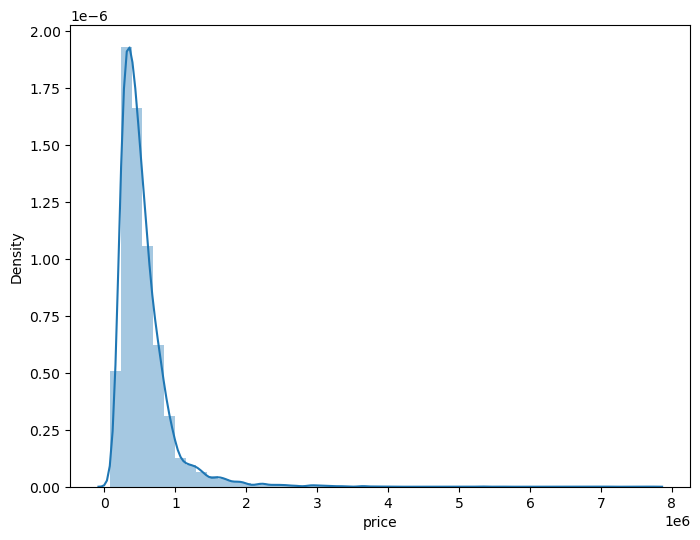

In [35]:
# Price에 대한 정규화

#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_train['price'])

<Axes: xlabel='price', ylabel='Density'>

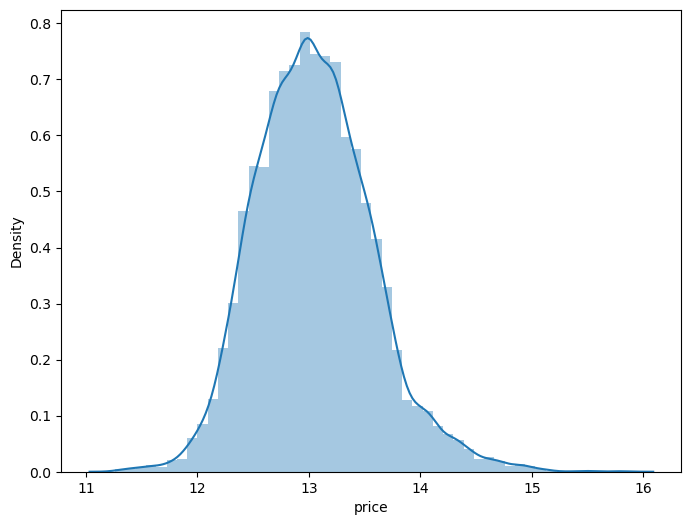

In [36]:
df_train['price'] = np.log1p(df_train['price'])
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_train['price'])

### 이상치 확인 및 제거

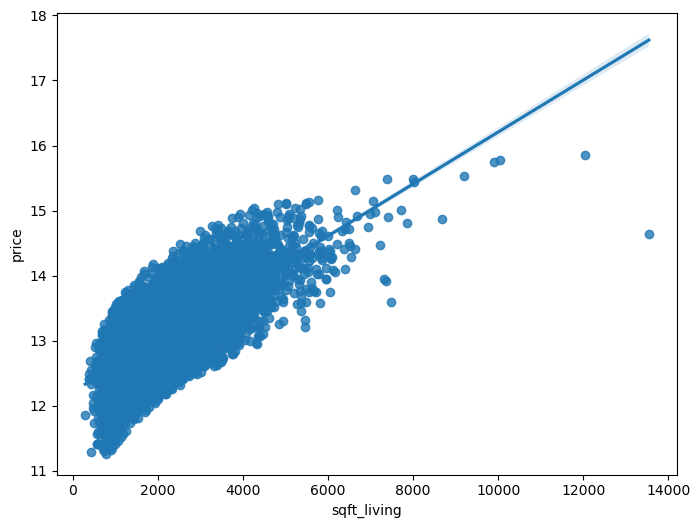

In [37]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [38]:
df_train.loc[df_train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [39]:
df_train = df_train.loc[df_train['id']!=8912]

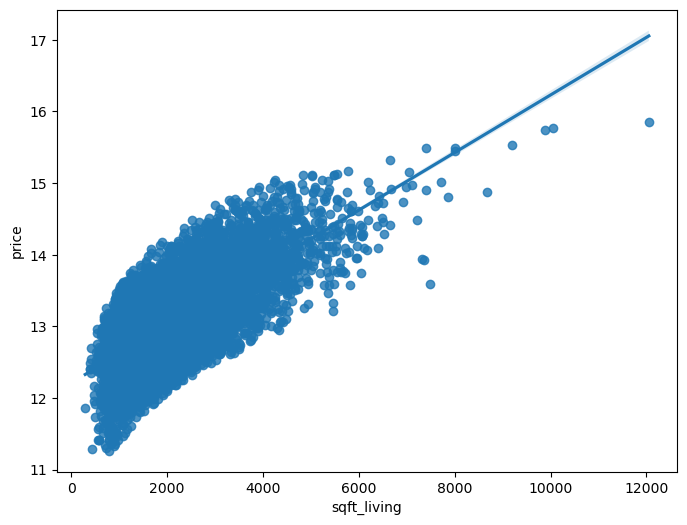

In [40]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

### grade

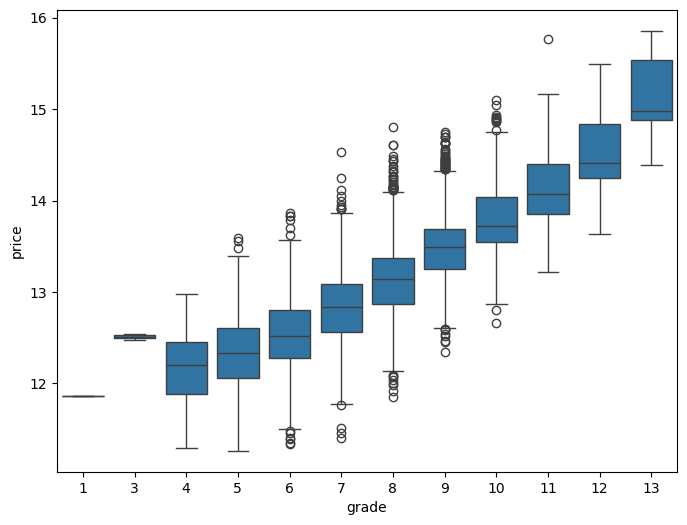

In [41]:
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

In [42]:
df_train.loc[(df_train['price']>12) & (df_train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [43]:
df_train.loc[(df_train['price']>14.7) & (df_train['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,20140813T000000,14.808763,5,4.0,4230,27295,2.0,1,4,...,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [44]:
df_train.loc[(df_train['price']>15.5) & (df_train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


In [45]:
df_train = df_train.loc[df_train['id']!=2302]
df_train = df_train.loc[df_train['id']!=4123]
df_train = df_train.loc[df_train['id']!=7173]
df_train = df_train.loc[df_train['id']!=2775]

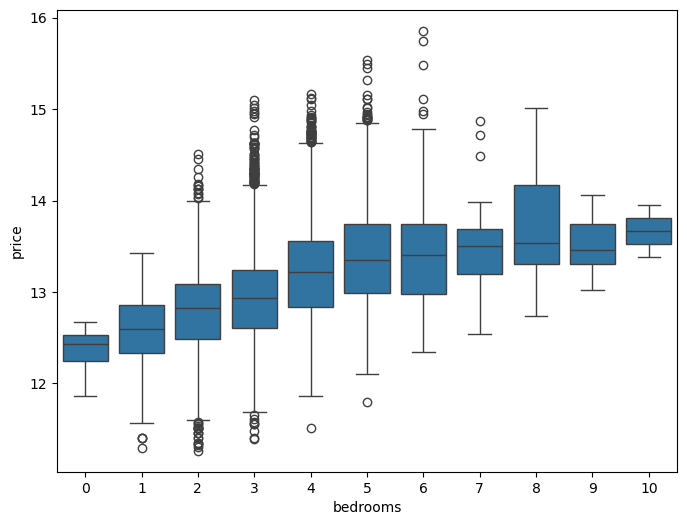

In [46]:
data = pd.concat([df_train['price'], df_train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

### 정규화

In [47]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    df_train[c] = np.log1p(df_train[c].values)
    df_sub[c] = np.log1p(df_sub[c].values)

In [48]:
for df in [df_train, df_sub]:
    df['date'] = df['date'].apply(lambda x: x[0:8])
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

### 변수 생성

In [49]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,...,7,7.074117,0.0,1955,1955.0,98178,47.5112,-122.257,1340,5650
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,...,6,6.647688,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,...,8,7.427144,0.0,1987,1987.0,98074,47.6168,-122.045,1800,7503
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,...,7,7.447751,0.0,1995,1995.0,98003,47.3097,-122.327,2238,6819
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,...,7,6.966967,0.0,1963,1963.0,98198,47.4095,-122.315,1650,9711


In [50]:
for df in [df_train, df_sub]:
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율 
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 면적 대비 거실의 비율 
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['date'] = df['date'].astype('int')

In [51]:
# 평당가격을 활용한 지역의 
df_train['per_price'] = df_train['price']/df_train['sqft_total_size']
zipcode_price = df_train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
df_train = pd.merge(df_train,zipcode_price,how='left',on='zipcode')
df_sub = pd.merge(df_sub,zipcode_price,how='left',on='zipcode')

for df in [df_train, df_sub]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean']; del df['var']

### 모델링

In [52]:
# 선형회귀
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

train_columns = [c for c in df_train.columns if c not in ['id','price','per_price']]

model = sm.OLS(df_train['price'].values, df_train[train_columns])
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.745e+06
Date:                Thu, 13 Feb 2025   Prob (F-statistic):                        0.00
Time:                        19:57:29   Log-Likelihood:                         -10.264
No. Observations:               15030   AIC:                                      70.53
Df Residuals:                   15005   BIC:                                      261.0
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train[train_columns], df_train['price'], test_size=0.2, random_state=980417)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12024, 27), (3006, 27), (12024,), (3006,))

In [62]:
from sklearn.metrics import mean_squared_error
# 다양한 모델
def rmse_log1p(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# 모델에 따른 스코어 계산하기
def get_scores(models, X_train, X_test, y_train, y_test):
    
    df = {}
    
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse_log1p(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

# 모델 불러오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=980417

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

#--------------------------------------------------------------------------

get_scores(models, X_train, X_test, y_train, y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4166
[LightGBM] [Info] Number of data points in the train set: 12024, number of used features: 27
[LightGBM] [Info] Start training from score 13.048294


,RMSE
RandomForestRegressor,133142.232912
GradientBoostingRegressor,131714.911060
XGBRegressor,129249.370062
LGBMRegressor,113092.572805


In [65]:
df_sub[train_columns].head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated,zipcode_mean,zipcode_var
0,20141209,3,2.25,7.852050,8.887791,2.0,0,0,3,7,...,1690,7639,5.25,0.883465,13.676905,0.574110,0.221233,1,19.243241,2.317027
1,20141209,4,3.00,7.581210,8.517393,1.0,0,0,5,7,...,1360,5000,7.00,0.890086,13.772040,0.550478,0.272000,0,18.113257,2.389816
2,20140512,4,4.50,8.598036,11.532051,1.0,0,0,3,11,...,4760,101930,8.50,0.745577,15.600098,0.551153,0.046699,0,25.917920,0.737584
3,20150415,3,1.00,7.484930,8.918784,1.0,0,0,3,7,...,1780,8113,4.00,0.839232,13.551911,0.552315,0.219401,0,19.759625,2.053191
4,20150312,3,2.50,7.544861,8.788898,2.0,0,0,3,7,...,2390,7570,5.50,0.858454,7.544861,1.000000,0.315720,0,11.947244,0.477170


In [66]:
# submission 데이터 예측하기
y_pred = lightgbm.predict(df_sub[train_columns])
y_pred = np.expm1(y_pred)

submission = pd.DataFrame(data=y_pred, index=df_sub['id'])
submission.head()

,0
id,
15035,4.941366e+05
15036,4.745089e+05
15037,1.394491e+06
15038,3.216163e+05
15039,3.311184e+05


In [67]:
submission = submission.reset_index()
submission = submission.rename({0:'price'}, axis=1)

# 결과 저장
my_submission_path = './'
submission.to_csv(my_submission_path + 'submission.csv', index=False)

submission.head()

,id,price
0,15035,4.941366e+05
1,15036,4.745089e+05
2,15037,1.394491e+06
3,15038,3.216163e+05
4,15039,3.311184e+05


### 앙상블

In [73]:
y_pred_df = pd.DataFrame()
for model in models:
    model_name = model.__class__.__name__

    y_pred = model.predict(X_test)

    y_pred_df[model_name] = y_pred

y_pred = y_pred_df.mean(axis=1)

score_rmse = rmse_log1p(y_pred, y_test)
print(f'{score_rmse=}')

score_rmse=120218.95749434117


In [75]:
y_pred_df = pd.DataFrame()
for model in models:
    model_name = model.__class__.__name__

    y_pred = model.predict(X_test)
    y_pred = np.expm1(y_pred)

    y_pred_df[model_name] = y_pred

y_pred = y_pred_df.mean(axis=1)

score_rmse = np.sqrt(mean_squared_error(y_pred, np.expm1(y_test)))
print(f'{score_rmse=}')

score_rmse=119358.57207747034


In [86]:
y_pred_df = pd.DataFrame()
for model in models:
    model_name = model.__class__.__name__

    y_pred = model.predict(df_sub[train_columns])

    y_pred_df[model_name] = y_pred

y_pred = y_pred_df.mean(axis=1).values

y_pred = np.expm1(y_pred)

submission = pd.DataFrame(data=y_pred, index=df_sub['id'])

submission = submission.reset_index()
submission = submission.rename({0:'price'}, axis=1)

# 결과 저장
my_submission_path = './'
submission.to_csv(my_submission_path + 'submission.csv', index=False)

submission.head()

,id,price
0,15035,5.014277e+05
1,15036,4.709028e+05
2,15037,1.381061e+06
3,15038,3.122327e+05
4,15039,3.260565e+05


In [88]:
y_pred_df = pd.DataFrame()
for model in models:
    model_name = model.__class__.__name__

    y_pred = model.predict(df_sub[train_columns])
    y_pred = np.expm1(y_pred)

    y_pred_df[model_name] = y_pred

y_pred = y_pred_df.mean(axis=1).values

submission = pd.DataFrame(data=y_pred, index=df_sub['id'])

submission = submission.reset_index()
submission = submission.rename({0:'price'}, axis=1)

# 결과 저장
my_submission_path = './'
submission.to_csv(my_submission_path + 'submission.csv', index=False)

submission.head()

,id,price
0,15035,5.017517e+05
1,15036,4.736511e+05
2,15037,1.387656e+06
3,15038,3.123974e+05
4,15039,3.262580e+05


In [70]:
y_pred_df = pd.DataFrame()
for model in models:
    model_name = model.__class__.__name__

    y_pred = model.predict(df_sub[train_columns])
    y_pred = np.expm1(y_pred)

    y_pred_df[model_name] = y_pred

y_pred_df.head()

,GradientBoostingRegressor,XGBRegressor,LGBMRegressor,RandomForestRegressor
0,5.328319e+05,4.941011e+05,4.941366e+05,4.859373e+05
1,3.929528e+05,5.196722e+05,4.745089e+05,5.074706e+05
2,1.203591e+06,1.585306e+06,1.394491e+06,1.367234e+06
3,3.232014e+05,3.002681e+05,3.216163e+05,3.045040e+05
4,3.069231e+05,3.358047e+05,3.311184e+05,3.311857e+05


In [ ]:
y_pred = y_pred_df.mean(axis=1)

0       5.017517e+05
1       4.736511e+05
2       1.387656e+06
3       3.123974e+05
4       3.262580e+05
            ...     
6463    2.421369e+05
6464    4.194098e+05
6465    4.623273e+05
6466    3.346328e+05
6467    4.221489e+05
Length: 6468, dtype: float64

In [ ]:
y_pred = lightgbm.predict(df_sub[train_columns])
y_pred = np.expm1(y_pred)

submission = pd.DataFrame(data=y_pred, index=df_sub['id'])
submission.head()